# Домашнее задание 2. StarGAN

### Загрузка данных
В данном задании вам предстоит работать с CelebA 64x64 и генерировать новые лица с заданными аттрибутами

In [1]:
import requests
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py'
open('celeba.py', 'wb').write(requests.get(url).content);
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt'
open('list_attr_celeba.txt', 'wb').write(requests.get(url).content);

In [2]:
from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os 

from torch import Tensor

Загрузим человекочитаемые названия доменов

In [3]:
with open('list_attr_celeba.txt', 'r') as f:
    attr_name = np.array(f.readline().split(' ')[:-1])
attr_name

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype='<U19')

In [4]:
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

Главная проблема мультидоменной генерации на селебе - наличие большого количества "бесполезных" классов, например 'Arched_Eyebrows', 'Attractive' 'Bags_Under_Eyes итд. Чтобы сделать задачу чуть проще, в этой домашке мы предлагаем вам взять 10 аттрибутов и учить im2im только на них

In [5]:
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        indices = [8, 9, 11, 15, 16, 20, 22, 28, 35, 39]
        image, target = super().__getitem__(idx)
        target = target['attributes'] == 1
        new_target = target[indices].float()
        if sum(new_target) == 0:
            return self.__getitem__(randint(0, len(self)-1))
        return image, new_target

In [6]:
attr_name = attr_name[[8, 9, 11, 15, 16, 20, 22, 28, 35, 39]]

In [7]:
crop = True
assert crop

dataset = CelebaCustomDataset(
    transform=transform,
    attr_file_path='list_attr_celeba.txt',
    crop=crop
)

img, attr = dataset[0]
img.shape

Downloading...
From: https://drive.google.com/uc?id=12agH1nWYcj7PAoErxQQgFdOAohgS9qE_
To: /content/data/celeba/img_align_celeba_crop.zip
100%|██████████| 3.55M/3.55M [00:00<00:00, 67.4MB/s]


torch.Size([3, 64, 64])

### Визуализация датасета

In [8]:
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

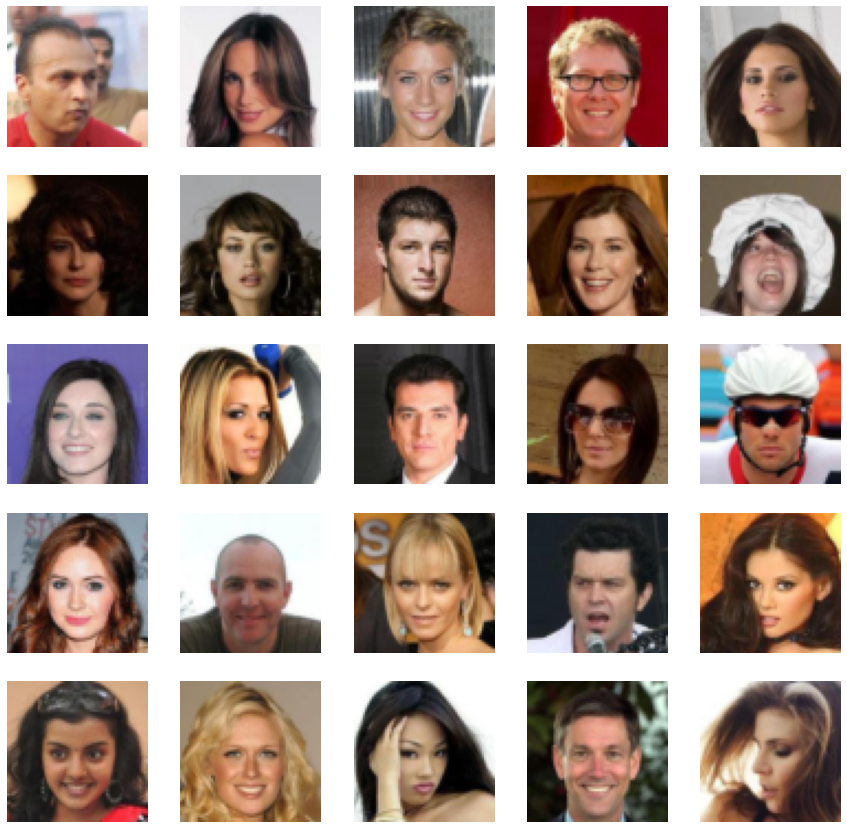

In [9]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img, attr = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1. Обучите low-res StarGanV1 на ограниченном подмножестве аттрибутов



В рамках данного задания предлагается реализовать и обучить [StarGAN v1](https://arxiv.org/pdf/1711.09020.pdf) для генерации лиц с заданными аттрибутами

<img src='https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/images/stargan_v1.png' width=600>

Вы можете добавлять любые дополнительные  параметры и использовать любые трюки для стабилизации/улучшения обучения на свое усмотрение. Ячейка для вспомогательных функций и классов:


In [10]:
### BEGIN SOLUTION
### END SOLUTION

Определите класс генератора.

In [11]:
class ConvINReLU(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride, padding):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.InstanceNorm2d(out_dim, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.net(x)

    
class UpConvReLU(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride, padding):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Upsample(scale_factor=(2, 2)),
            nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.InstanceNorm2d(out_dim, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.net(x)


class Generator(nn.Module):
    def __init__(self, emb_channels=10):
        """
        you can use any parameters here, for example ->
        hidden_dim: number of channels used in convs 
        """
        super().__init__()
        ### BEGIN SOLUTION
        self.downsample = nn.Sequential(
            ConvINReLU(emb_channels + 3, 64, kernel_size=7, stride=1, padding=3),
            ConvINReLU(64, 128, kernel_size=4, stride=2, padding=1),
            ConvINReLU(128, 256, kernel_size=4, stride=2, padding=1)
        )
        
        self.bottleneck = nn.Sequential(
            *[ConvINReLU(256, 256, kernel_size=3, stride=1, padding=1) for i in range(3)]
        )
        
        self.upsampling = nn.Sequential(
            UpConvReLU(256, 128, kernel_size=3, stride=1, padding=1),
            UpConvReLU(128, 64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
        ### END SOLUTION

    def forward(self, x: Tensor, y: Tensor):
        """
        x: original image 
        y: target domain
        """
        ### BEGIN SOLUTION
        y = y[(..., ) + (None, ) * 2].repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat((x, y), dim=1)
        
        x = self.downsample(x)
        x = self.bottleneck(x)
        x = self.upsampling(x)
        
        return x
        ### END SOLUTION


Определите класс дискриминатора

In [12]:
class ConvLeakyReLU(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride, padding):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(0.01)
        )
        
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, nd=10):
        super().__init__()
        ### BEGIN SOLUTION
        self.back_model = nn.Sequential(
            ConvLeakyReLU(3, 64, kernel_size=4, stride=2, padding=1),
            ConvLeakyReLU(64, 128, kernel_size=4, stride=2, padding=1),
            ConvLeakyReLU(128, 256, kernel_size=4, stride=2, padding=1),
            ConvLeakyReLU(256, 512, kernel_size=4, stride=2, padding=1),
            ConvLeakyReLU(512, 1024, kernel_size=4, stride=2, padding=1),
#             ConvLeakyReLU(1024, 2048, kernel_size=4, stride=2, padding=1),
        )
        
        self.image_discriminator = nn.Sequential(
            nn.Conv2d(1024, 1, kernel_size=3, stride=1, padding=1)
        )
        
        self.class_discriminator = nn.Sequential(
            nn.Conv2d(1024, nd, kernel_size=2, stride=1, padding=0)
        )
        ### END SOLUTION

    def forward(self, x: Tensor):
        ### BEGIN SOLUTION
        x = self.back_model(x)
        
        d_image = self.image_discriminator(x)
        d_class = self.class_discriminator(x)
                        
        return d_image, d_class.squeeze()
        ### END SOLUTION

Определите функцию load_generator, которая загружает веса из облака, например с помощью gdown, и возвращает генератор.

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert device == 'cpu'

In [14]:
def load_generator():
    #!pip install gdown
    import gdown
    url = 'https://drive.google.com/u/0/uc?id=1fUrJnW2Egiamzp7J3PZsfW4libgADxii&export=download'
    gdown.download(url, 'gen.weights', fuzzy=True)
    gen = Generator().to(device)
    gen.load_state_dict(torch.load('gen.weights', map_location=device))
    return gen
    ### BEGIN SOLUTION
    ### END SOLUTION

In [15]:
generator = load_generator()
generator

Downloading...
From: https://drive.google.com/uc?id=1fUrJnW2Egiamzp7J3PZsfW4libgADxii
To: /content/gen.weights
100%|██████████| 11.4M/11.4M [00:00<00:00, 38.7MB/s]


Generator(
  (downsample): Sequential(
    (0): ConvINReLU(
      (net): Sequential(
        (0): Conv2d(13, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvINReLU(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): ConvINReLU(
      (net): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (bottleneck): Sequential(
    (0): ConvINReLU(
      (net): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256,

In [16]:
param_size = 0
for param in generator.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in generator.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
gen_size = (param_size + buffer_size) / 1024**2
assert gen_size < 100

In [17]:
print(f"generator size: {gen_size:.3f} MB")

generator size: 10.875 MB


Визуализация работы генератора

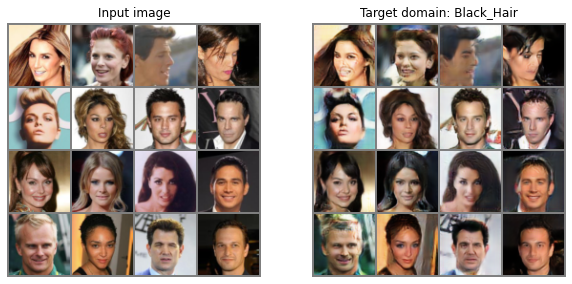

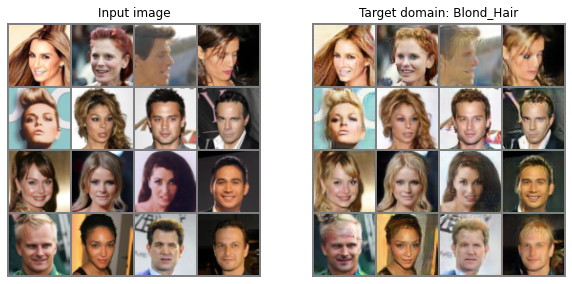

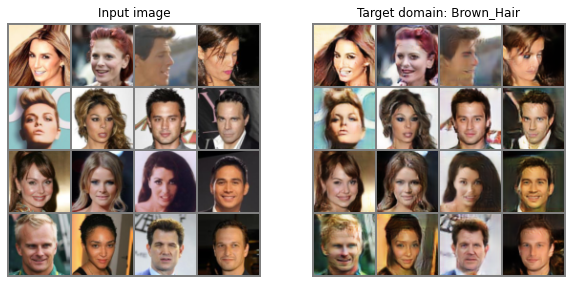

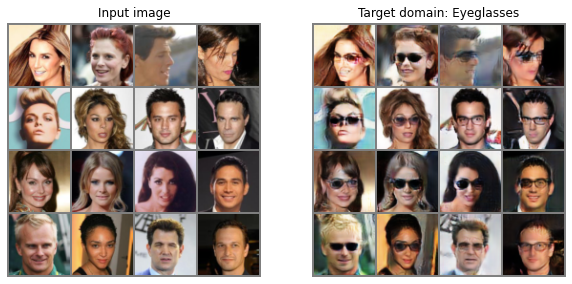

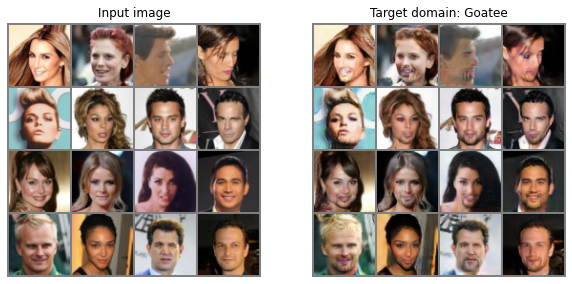

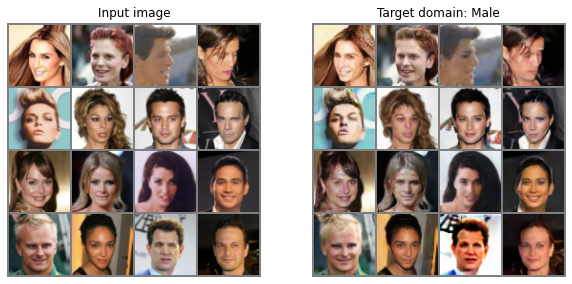

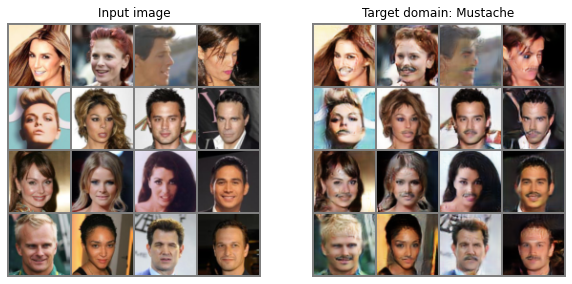

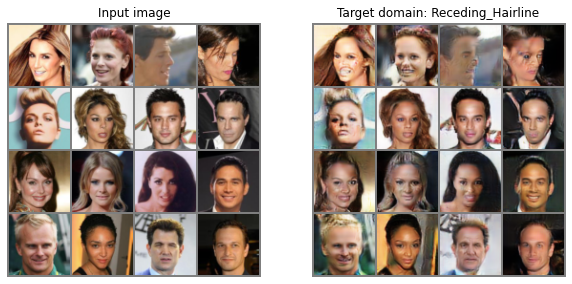

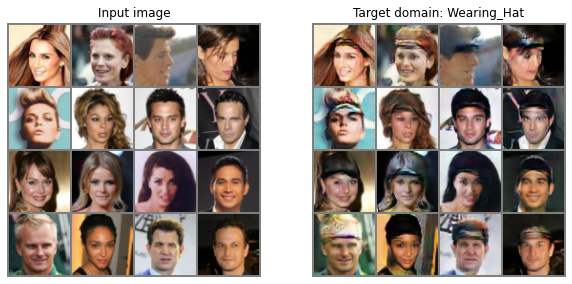

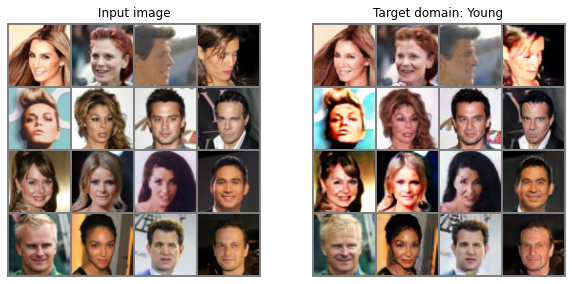

In [18]:
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=16, 
    drop_last=True)
x_real, y_real = next(iter(dataloader))
y_real = y_real.float()
x_real, y_real = x_real.to(device), y_real.to(device)
for label_index in range(10):
    y_trg = y_real.clone()
    y_trg[:, label_index] = 1 - y_trg[:, label_index] # reverse
    with torch.no_grad():
        x_fake = generator(x_real, y_trg)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    x_show = make_grid(x_real, nrow=4, normalize=False).detach().cpu()
    plot_img(x_show, t_invnormalize)
    plt.title(f'Input image')
    plt.subplot(1, 2, 2)
    x_show = make_grid(x_fake, nrow=4, normalize=False).detach().cpu()
    plot_img(x_show, t_invnormalize)
    plt.title(f'Target domain: {attr_name[label_index]}')

Во время обучения вы можете считать FID вашей модели, но для автопроверки мы решили использовать LPIPS — [Learned Perceptual Image Patch Similarity](https://arxiv.org/abs/1801.03924) как финальную метрику качества. 

In [19]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git -q

from lpips_pytorch import LPIPS
lpips = LPIPS().to(device)

    Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

Ячейка на 4 балла:

In [20]:
def evaluate_model(dataloader, generator):
    values = []
    for x_real, label in tqdm(dataloader):
        x_real, label = x_real.to(device), label.to(device).float()
        target_domain = label.flip(dims=[0])
        with torch.no_grad():
            x_fake = generator(x_real, target_domain)
        values.append(lpips(x_fake, x_real).squeeze().item())
    return np.mean(values)
    
eval_dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=1
)
len(eval_dataloader)

lpips_score = evaluate_model(eval_dataloader, generator)
assert lpips_score < 1

  0%|          | 0/500 [00:00<?, ?it/s]

Ячейка на 3 балла:

In [21]:
assert lpips_score < 0.1

Ячейка на 3 балла:

In [22]:
assert lpips_score < 0.06

In [23]:
round(lpips_score, 4)

0.0483

### Задача 2. Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **1+ балл**
1. Посмотрите получается ли у вас интерполяция в латентном пространстве
2. Покажите на каких доменах ваша модель работает хорошо, на каких не очень.
3. Попробуйте взять внешнюю картинку (не из селебы) и повторить результат.
4. Покажите самый смешной результат мультидоменной перекраски который у вас получался

* Текстовое ревью решения и предложения возможных улучшений - **1+ балл**
1. Опишите как вы решали задачу, какие методы описанные в статье вы использовали. Какие методы из других статей вы пробовали применять, что дало наибольший прирост в качестве?
2. Что бы вы предложили использовать еще, какие возможные улучшения здесь бы еще помогли получить бОльшее качество?


За хороший текст/результаты в этой задаче и за хорошее качество обученных моделей мы можем дать дополнительные баллы которые можно будет прибавить к другим домашкам :)

Эта задача выполняется отдельно и загружается в виде PDF в Anytask